# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)

AUTHOR_ID_NRS = ['1940198', '1981706', '1966561', '1932381']

#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

1a.

Three hypothesis generated as a team during first meeting:

Hypothesis 1: Temperature and fog display similar effects on O<sub>3</sub> concentration levels throughout the year. 

Hypothesis 2: An increase in temperature leads to a higher concentration of NO in the north of the Netherlands as compared to the south.

Hypothesis 3: There is positive correlation between fog density and NH<sub>3</sub> concentration, with the strength of correlation varying with season.


Brief motivation on our interest and outcome for the hypotheses:

According to our GA1 analysis, we notice that there seems to be a seasonal correlation between temperature. fog and specifically NO/NH<sub>3</sub> concentration. The strength of a correlation with temperature seems be more explicit with these two compounds as compared to other pollutants, which is what originally our attention and interest in formulating these three hypothesis. 

We believe that regardless of the chosen hypothesis, we expect to see a strong correlation between any pair of weather factor and compound, with higher peak compound concentration in the winter months as opposed to the warmer months of the year.

----------------------------------------------------------------------
----------------------------------------------------------------------



Main idea:
We believe that according to the data, the northmost region of the Netherlands, Groningen, which has relatively lower temperature levels has a higher concentration of NO compared to the southernmost region of the Netherlands, Limburg, which has relatively higher temperature levels. We have decided to focus on this main assumption as a basis for exploration so we are choosing hypothesis number 2.

Chosen hypothesis (basic):
An increase in temperature leads to a higher concentration of NO in the north of the Netherlands as compared to the south.


## Part 1b: Hypothesis refinement

1b.

1. Annotating, brainstorming, and answering questions on keywords of the original hypothesis:

Original hypothesis: An <u>increase in temperature</u> leads to a <u>higher concentration</u> of NO in the <u>north of the Netherlands as compared to the south</u>.

<u>Increase in temperature</u>:
What increase? How much of an increase? What season?

Obviously the independent variable has been decided as (the change in) temperature. What remains to be decided is in what context this will be measured in as a simple change in temperature is too simple and not worth investigating. 

It is already clear that a lower temperature results in a higher NO concentration according to GA1. This is true on its own for one measuring station. Now we are going to investigate if the trend holds for different regions of the country or if other factors influence the results. For now, we have decided to investigate the north and south regions (specifically the area around Groningen/Friesland as contrasted to the Limburg area) as it is clear that these regions have the most signicant average changes in temperature as compared to other provinces.

<u>Higher concentration of NO</u>:
Peak or average? Measured per day, week, month, season?

We are going to be measuring NO concentration peaks and means for each region solely in the winter period as this is a good focus season due to the amount of extreme recordings of NO concentration occuring at this time.

<u>North of the netherlands as compared to the south or any other region</u>
We can choose to explore and compare (pairs of) different provinces or regions, such as Groningen and Limburg, for example which should have a measurable amount of average temperature difference. We will be doing this for seperate four regions and comparing them.


2. Refined hypothesis:
Dutch regions with average winter temperatures lower than 4.5 degrees Celsius record higher instances of NO concentration peaks over the winter median NO concentration of the country than those over 4.5 degrees average winter temperatures.

3. Choosing the measuring stations:
We choose the measuring stations based on different geographical regions of the Netherlands - north, south, south-west, and east.

4. Our approach:
First, we query data from the tables in the database and create dataframes with data based on our chosen regions. We get the average temperature of each region in the winter period, then get the median of NO concentration of the country for the same period (we use the median to take into account for outliers). Then, we clean the data and use the results to test our hypothesis.

5. Possible confounding variables:
Some confounding variables could be the population density (which contributes to pollution levels), pollution from fossil fuel production in different regions, percentage of population living in urban or rural areas - more farms in rural areas contribute to higher NO concentration levels, and higher or lower humidity depending on proxiomity to coast.




## Part 2: Queries and data cleaning

<h3>Part 2a: Obtain station codes</h3>

In [3]:
# Tim, David, Arhan, Eytan

# Function to calculate distance between two points (might be needed)

from math import atan2, cos, radians, sin, sqrt
def great_circle_distance(point1: tuple[float, float], point2: tuple[float, float]) -> float:
    """
    Uses the haversine formula to compute the distance (m) between two
    points (latitude, longitude) in coordinates (in degrees).
    Adapted from http://www.movable-type.co.uk/scripts/latlong.html.
    :param point1: tuple whose first item represents the latitude, and
        its second item the longitude of a point in degrees
    :param point2: tuple whose first item represents the latitude, and
        its second item the longitude of a point in degrees
    :return: great-circle distance between the two points in meters
    """
    r = 6371e3  # radius of the earth, in meters

    latitude1_deg, longitude1_deg = point1  # in degrees
    latitude2_deg, longitude2_deg = point2  # in degrees

    latitude1_rad = radians(latitude1_deg)  # in radians
    latitude2_rad = radians(latitude2_deg)  # in radians

    latitude_delta = radians(latitude2_deg - latitude1_deg)
    longitude_delta = radians(longitude2_deg - longitude1_deg)

    a = sin(latitude_delta / 2) ** 2 + cos(latitude1_rad) * cos(latitude2_rad) * sin(longitude_delta / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return r * c

In [4]:
# Connect to SQL database

db = sqlite3.connect('datasets/aqw.db')


In [5]:
# David, Arhan (until part 2b)

# Only get necessary stations 

def get_stations(database):
    
    # air quality stations
    aqs_query = '''
        SELECT name, latitude, longitude, code,
        CASE
            WHEN latitude > 52.8 AND longitude > 6 THEN 'north'
            WHEN latitude < 51 THEN 'south'
            WHEN latitude > 51.8 AND latitude < 52.2 AND longitude < 4.6 AND longitude > 4 THEN 'southwest'
            WHEN latitude < 52.5 AND longitude > 6.5 THEN 'east'
            ELSE 'other'
        END as region
        FROM air_quality_stations
        WHERE (latitude > 52.8 AND longitude > 6) OR latitude < 51 OR (latitude > 51.8 AND latitude < 52.2 AND longitude < 4.6 AND longitude > 4) or (latitude < 52.5 AND longitude > 6.5)
    '''
    # weather stations
    ws_query = '''
        SELECT name, latitude, longitude, code,
        CASE
            WHEN latitude > 52.8 AND longitude > 6 THEN 'north'
            WHEN latitude < 51 THEN 'south'
            WHEN latitude > 51.8 AND latitude < 52.2 AND longitude < 4.6 AND longitude > 4 THEN 'southwest'
            WHEN latitude < 52.5 AND longitude > 6.5 THEN 'east'
            ELSE 'other'
        END as region
        FROM weather_stations
        WHERE (latitude > 52.8 AND longitude > 6) OR latitude < 51 OR (latitude > 51.8 AND latitude < 52.2 AND longitude < 4.6 AND longitude > 4) OR (latitude < 52.5 AND longitude > 6.5)
    '''
    
    df_aqs = pd.read_sql_query(aqs_query, database)
    df_ws = pd.read_sql_query(ws_query, database)
    
    # colors of the dots on the map
    df_aqs['color'] = "#5499c7"
    df_ws['color'] = "#ff8f35"
    
    # type of station (for the df_stations dataframe)
    df_aqs['type'] = 'air quality station'
    df_ws['type'] = 'weather station'
    
    return pd.concat([df_ws, df_aqs])

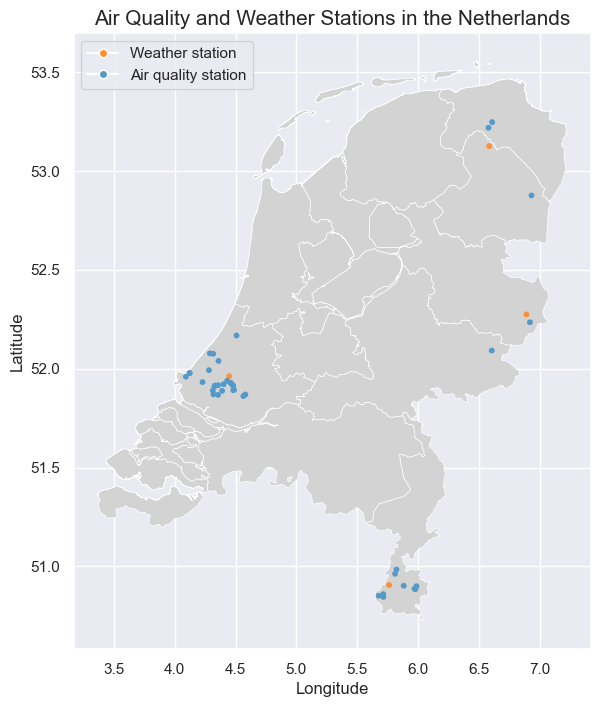

In [6]:
# plot stations on map

from matplotlib.lines import Line2D
from shapely.geometry import Point
import geopandas as gpd

def plot_stations_on_map(df_stations):
    map_nl = gpd.read_file('./datasets/stanford-st293bj4601-shapefile.zip')

    gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(df_stations['longitude'], df_stations['latitude'])])
    gdf['color'] = list(df_stations['color'])
    gdf.crs = map_nl.crs

    f, ax = plt.subplots(1, figsize=(8, 8))

    map_nl.plot(linewidth=0.5, edgecolor='white', color='lightgrey',legend=True, ax=ax)
    gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=10)

    ax.set_title('Air Quality and Weather Stations in the Netherlands', size=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    legend = [
        Line2D([0], [0], markerfacecolor='#FF8F35', marker='o', color='w', label='Weather station'),
        Line2D([0], [0], markerfacecolor='#5499C7', marker='o', color='w', label='Air quality station')
    ]
    ax.legend(handles=legend, loc='upper left')
    return ax

df_stations = get_stations(db)

plot_stations_on_map(df_stations);

In [7]:
# Data Frame with all selected stations.

"""
    There are 2 weather stations (Eelde, Maastricht), with their codes being 3 digit numbers;
    There are 9 air quality stations, with their codes being of the form 'NL' followed by 5 digits.
    We can use the 'code' column of this dataframe to select relevant information from our databases.
"""

df_stations.sort_values(['region', 'type'], inplace=True)
df_stations.set_index(['region', 'type', 'code'], inplace=True)
df_stations

name  \
region    type                code                                           
east      air quality station NL10821                Enschede-Winkelhorst.   
                              NL10722               Eibergen-Lintveldseweg   
          weather station     290                                  Twenthe   
north     air quality station NL10937                  Groningen-Europaweg   
                              NL10938            Groningen-Nijensteinheerd   
                              NL10929              Valthermond-Noorderdiep   
          weather station     280                                    Eelde   
south     air quality station NL10136                 Heerlen-Looierstraat   
                              NL10138                  Heerlen-Jamboreepad   
                              NL10133         Wijnandsrade-Opfergeltstraat   
                              NL10137         Heerlen-Deken Nicolayestraat   
                              NL50003                   Geleen-Asterstraat   
                              NL50004             Maastricht-A2 Nassaulaan   
                              NL50002                     Geleen-Vouershof   
                              NL50007              Maastricht-Hoge Fronten   
                              NL50009  Maastricht-A2 Kasteel Hillenraadweg   
          weather station     380                               Maastricht   
southwest air quality station NL10404              Den Haag-Rebecquestraat   
                              NL10418             Rotterdam-Schiedamsevest   
                              NL10448              Rotterdam-Bentinckplein   
                              NL10449                Vlaardingen-Riouwlaan   
                              NL10445                    Den Haag-Veerkade   
                              NL10446                 Den Haag-Bleriotlaan   
                              NL01484                  Botlek-Oude Maasweg   
                              NL01485                   Hoogvliet-Leemkuil   
                              NL01495                Maassluis-Kwartellaan   
                              NL01496            Hoek v. Holland-Berghaven   
                              NL01487              Rotterdam Zuid-Pleinweg   
                              NL01488      Rotterdam Zuid-Zwartewaalstraat   
                              NL01489                   Ridderkerk-Hogeweg   
                              NL01491         Rotterdam-Oost Sidelinge A13   
                              NL01493           Rotterdam Noord -Statenweg   
                              NL01494         Schiedam-Alphons Arienstraat   
                              NL01912                   Ridderkerk-Voorweg   
                              NL01483                   Botlek-Spoortunnel   
                              NL01486                   Pernis-Soetemanweg   
                              NL10433               Vlaardingen-Floreslaan   
                              NL01482                    Europoort-Markweg   
                              NL10411               Schipluiden-Groeneveld   
                              NL10416               Vlaardingen-Lyceumlaan   
                              NL01492                  Rotterdam-Vasteland   
                              NL10432           Hoek van Holland-Berghaven   
                              NL10447         Leiden-Willem de Zwijgerlaan   
          weather station     344                                Rotterdam   

                                        latitude  longitude    color  
region    type                code                                    
east      air quality station NL10821  52.234504   6.919494  #5499c7  
                              NL10722  52.091801   6.605367  #5499c7  
          weather station     290      52.274000   6.891000  #ff8f35  
north     air quality station NL10937  53.217796   6.578901  #5499c7  
                              NL10938  53.246535   6.60

In [8]:
# Get info on NO concentration levels

QUERY_AQ = f"""
    SELECT datetime, {'no'}
    FROM air_quality_data 
"""


df_aq = pd.read_sql_query(QUERY_AQ, db, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

df_aq

,no
datetime,
2012-01-01 01:00:00+01:00,6.0
2012-01-01 01:00:00+01:00,78.0
2012-01-01 01:00:00+01:00,NaN
2012-01-01 01:00:00+01:00,1.4
2012-01-01 01:00:00+01:00,12.1
...,...
2021-12-31 23:00:00+01:00,NaN
2021-12-31 23:00:00+01:00,NaN
2021-12-31 23:00:00+01:00,NaN


In [9]:
#NOTE WHEN PROGRAMMING
#Steps to take to answer hypothesis:

#Calculate average winter temperature of north and south regions seperately (end result: two seperate numbers)
#This can probably be done by setting limit of the dates (winter season is defined as 22nd December to 20th March) and then computing average of all weather stations in the region

#Calculate median NO concentration of the whole country during the winter period (22nd Dec - 20th March): (end result: one number)
#There can be two methods to calculate the median: one is to find average NO concentration of north and south seperately and the median would just be there average (since its only two regions, there would only be two numbers)
#Other way is to use all stations function from the help doc to find median of the whole country in one go

#Set up tables/dataframes of NO concentration, temp, per region (possibly include avg over the season, average per month, etc)
#One necessary column to include in table: count the number of instances that the NO concentration exceedes the national median NO 

#Extra analysis after main stuff is over: Use diff() function on dataframe to calculate biggest drops in temp. over a day to see how it affects the rise in NO concentration

<h3>Part 2b: Retrieve data from the database</h3>

We want to select data from the tables in our database strictly for the stations which we are studying. To this end, we will make use of our <b>df_stations</b> dataframe object, which has the station code as the outer index. We can use these codes to create SQL queries and select relevant data from the <b>db</b> database, but we must first convert the <i>'code'</i> column of <b>df_stations</b> into a format that can be used in an SQL query.

To do this, we will insert the values of the <i>'code'</i> column into a list, then make it into a string of codes from our dataframe. Each code should be surrounded by quotation marks and separated by commas. We can achieve this by code similar to the following:
```
    codes = df_stations.index.get_level_values('code').tolist()
    codes_str = ', '.join([f"'{code}'" for code in codes])
``` 
   
#Furthermore, to ease the process of obtaining relevant data, we will create two separate strings - one with the air quality station codes, and one with the weather station codes. We shall achieve this by creating a boolean mask and selecting the codes of the rows marked 'air quality station' and 'weather station' in particular, and then following the code snippet above.

In [10]:
# David (until 2c)

mask = df_stations.index.get_level_values('type') == 'air quality station'
codes_aq = df_stations[mask].index.get_level_values('code').tolist()
codes_aq_str = ', '.join([f"'{code}'" for code in codes_aq])

mask = df_stations.index.get_level_values('type') == 'weather station'
codes_w = df_stations[mask].index.get_level_values('code').tolist()
codes_w_str = ', '.join([f"'{code}'" for code in codes_w])

And our resulting strings <b>codes_aq_str</b>, containing the codes for the <i>air quality stations</i>, and <b>codes_w_str</b>, containing the codes for the <i>weather stations</i>:

In [11]:
codes_aq_str, codes_w_str

("'NL10821', 'NL10722', 'NL10937', 'NL10938', 'NL10929', 'NL10136', 'NL10138', 'NL10133', 'NL10137', 'NL50003', 'NL50004', 'NL50002', 'NL50007', 'NL50009', 'NL10404', 'NL10418', 'NL10448', 'NL10449', 'NL10445', 'NL10446', 'NL01484', 'NL01485', 'NL01495', 'NL01496', 'NL01487', 'NL01488', 'NL01489', 'NL01491', 'NL01493', 'NL01494', 'NL01912', 'NL01483', 'NL01486', 'NL10433', 'NL01482', 'NL10411', 'NL10416', 'NL01492', 'NL10432', 'NL10447'",
 "'290', '280', '380', '344'")

Now, using the string objects we have created above, we can create SQL queries to extract data from our database.
Firstly, we will use <i>codes_aq_str</i> to extract data about <b>NO</b> concentration levels from the air quality stations we are studying:

In [12]:
no_query = f'''
    SELECT no, datetime, station_code
    FROM air_quality_data
    WHERE station_code IN ({codes_aq_str})
    GROUP BY station_code, datetime
'''

df_no = pd.read_sql_query(no_query, db)

In [13]:
df_no

,no,datetime,station_code
0,NaN,2012-01-01 01:00:00+01:00,NL01482
1,NaN,2012-01-01 02:00:00+01:00,NL01482
2,NaN,2012-01-01 03:00:00+01:00,NL01482
3,NaN,2012-01-01 04:00:00+01:00,NL01482
4,NaN,2012-01-01 05:00:00+01:00,NL01482
...,...,...,...
2691545,NaN,2020-12-31 20:00:00+01:00,NL50009
2691546,NaN,2020-12-31 21:00:00+01:00,NL50009
2691547,NaN,2020-12-31 22:00:00+01:00,NL50009
2691548,NaN,2020-12-31 23:00:00+01:00,NL50009


Similarly, we will use <i>codes_w_str</i> to extract data about <b>temperature</b> levels from our weather stations:

In [14]:
temp_query = f'''
    SELECT temperature, datetime, station_code
    FROM weather_data
    WHERE station_code IN ({codes_w_str})
    GROUP BY station_code, datetime
'''

df_temp = pd.read_sql_query(temp_query, db)

In [15]:
df_temp

,temperature,datetime,station_code
0,10.2,2012-01-01 00:00:00+01:00,280
1,10.0,2012-01-01 01:00:00+01:00,280
2,10.1,2012-01-01 02:00:00+01:00,280
3,10.4,2012-01-01 03:00:00+01:00,280
4,10.6,2012-01-01 04:00:00+01:00,280
...,...,...,...
350683,12.7,2021-12-31 19:00:00+01:00,380
350684,12.8,2021-12-31 20:00:00+01:00,380
350685,12.7,2021-12-31 21:00:00+01:00,380
350686,12.7,2021-12-31 22:00:00+01:00,380


Having created the dataframes with data for all relevant air quality stations, respectively weather stations, we shall split the dataframes into new ones containing data for all of the northern stations, respectively all of the southern stations, to ease further analysis of our hypothesis.

We will first split the data from our air quality stations based on the region of the air quality station - either 'north' or 'south'. We will do this by using the <i>pandas</i> function ```pd.merge()``` on the <i>df_no</i> and <i>df_stations</i> (with resetted indices) on the station code.

In [16]:
df_reset = df_stations.reset_index()

df_merged = pd.merge(df_no, df_reset, left_on='station_code', right_on='code', how='left')

df_merged

,no,datetime,station_code,region,type,code,name,latitude,longitude,color
0,NaN,2012-01-01 01:00:00+01:00,NL01482,southwest,air quality station,NL01482,Europoort-Markweg,51.959417,4.091394,#5499c7
1,NaN,2012-01-01 02:00:00+01:00,NL01482,southwest,air quality station,NL01482,Europoort-Markweg,51.959417,4.091394,#5499c7
2,NaN,2012-01-01 03:00:00+01:00,NL01482,southwest,air quality station,NL01482,Europoort-Markweg,51.959417,4.091394,#5499c7
3,NaN,2012-01-01 04:00:00+01:00,NL01482,southwest,air quality station,NL01482,Europoort-Markweg,51.959417,4.091394,#5499c7
4,NaN,2012-01-01 05:00:00+01:00,NL01482,southwest,air quality station,NL01482,Europoort-Markweg,51.959417,4.091394,#5499c7
...,...,...,...,...,...,...,...,...,...,...
2691545,NaN,2020-12-31 20:00:00+01:00,NL50009,south,air quality station,NL50009,Maastricht-A2 Kasteel Hillenraadweg,50.859810,5.713810,#5499c7
2691546,NaN,2020-12-31 21:00:00+01:00,NL50009,south,air quality station,NL50009,Maastricht-A2 Kasteel Hillenraadweg,50.859810,5.713810,#5499c7
2691547,NaN,2020-12-31 22:00:00+01:00,NL50009,south,air quality station,NL50009,Maastricht-A2 Kasteel Hillenraadweg,50.859810,5.713810,#5499c7
2691548,NaN,2020-12-31 23:00:00+01:00,NL50009,south,air quality station,NL50009,Maastricht-A2 Kasteel Hillenraadweg,50.859810,5.713810,#5499c7


Before splitting the dataframe by 'north' and 'south', we should delete any unecessary columns - in our case, the columns 'name', 'latitude', 'longitude', 'type' and 'color' are redundant, as well as 'code' , as it has the same entries as 'station_code', so we will drop them using the <i>pandas</i> function `pd.drop`.

In [17]:
df_merged = df_merged.drop(columns=['type', 'code', 'name', 'latitude', 'longitude', 'color'])

df_merged

,no,datetime,station_code,region
0,NaN,2012-01-01 01:00:00+01:00,NL01482,southwest
1,NaN,2012-01-01 02:00:00+01:00,NL01482,southwest
2,NaN,2012-01-01 03:00:00+01:00,NL01482,southwest
3,NaN,2012-01-01 04:00:00+01:00,NL01482,southwest
4,NaN,2012-01-01 05:00:00+01:00,NL01482,southwest
...,...,...,...,...
2691545,NaN,2020-12-31 20:00:00+01:00,NL50009,south
2691546,NaN,2020-12-31 21:00:00+01:00,NL50009,south
2691547,NaN,2020-12-31 22:00:00+01:00,NL50009,south
2691548,NaN,2020-12-31 23:00:00+01:00,NL50009,south


As our merged dataframe is now ready, we can split it into <i>df_no_north</i>, which contains entries of NO concentration levels per datetime per every northern air quality station in our data set, respectively <i>df_no_south</i>, which is defined analogously.

In [18]:
df_no_north = df_merged[df_merged['region'] == 'north']

# The data frame only contains northern air quality stations, therefore we can drop the 'region' column
df_no_north = df_no_north.drop(columns=['region'])

df_no_north.set_index(['station_code', 'datetime'], inplace=True)

df_no_north

no
station_code datetime                        
NL10929      2012-01-01 01:00:00+01:00   0.58
             2012-01-01 02:00:00+01:00   0.16
             2012-01-01 03:00:00+01:00   0.17
             2012-01-01 04:00:00+01:00   0.05
             2012-01-01 05:00:00+01:00  -0.03
...                                       ...
NL10938      2021-12-31 19:00:00+01:00   1.30
             2021-12-31 20:00:00+01:00   7.45
             2021-12-31 21:00:00+01:00   6.87
             2021-12-31 22:00:00+01:00  10.79
             2021-12-31 23:00:00+01:00   2.20

[263013 rows x 1 columns]

In [19]:
df_no_south = df_merged[df_merged['region'] == 'south']

df_no_south = df_no_south.drop(columns=['region'])

df_no_south.set_index(['station_code', 'datetime'], inplace=True)

df_no_south

no
station_code datetime                       
NL10133      2012-01-01 01:00:00+01:00  0.49
             2012-01-01 02:00:00+01:00  0.35
             2012-01-01 03:00:00+01:00  0.21
             2012-01-01 04:00:00+01:00  0.27
             2012-01-01 05:00:00+01:00  0.32
...                                      ...
NL50009      2020-12-31 20:00:00+01:00   NaN
             2020-12-31 21:00:00+01:00   NaN
             2020-12-31 22:00:00+01:00   NaN
             2020-12-31 23:00:00+01:00   NaN
             2021-01-01 00:00:00+01:00   NaN

[543573 rows x 1 columns]

In [20]:
df_no_southwest = df_merged[df_merged['region'] == 'southwest']

# The data frame only contains northern air quality stations, therefore we can drop the 'region' column
df_no_southwest = df_no_southwest.drop(columns=['region'])

df_no_southwest.set_index(['station_code', 'datetime'], inplace=True)

df_no_southwest

no
station_code datetime                       
NL01482      2012-01-01 01:00:00+01:00   NaN
             2012-01-01 02:00:00+01:00   NaN
             2012-01-01 03:00:00+01:00   NaN
             2012-01-01 04:00:00+01:00   NaN
             2012-01-01 05:00:00+01:00   NaN
...                                      ...
NL10449      2021-12-31 19:00:00+01:00  2.30
             2021-12-31 20:00:00+01:00  2.59
             2021-12-31 21:00:00+01:00  4.90
             2021-12-31 22:00:00+01:00  3.28
             2021-12-31 23:00:00+01:00  3.36

[1727166 rows x 1 columns]

In [21]:
df_no_southwest = df_merged[df_merged['region'] == 'southwest']

# The data frame only contains northern air quality stations, therefore we can drop the 'region' column
df_no_southwest = df_no_southwest.drop(columns=['region'])

df_no_southwest.set_index(['station_code', 'datetime'], inplace=True)

df_no_southwest

no
station_code datetime                       
NL01482      2012-01-01 01:00:00+01:00   NaN
             2012-01-01 02:00:00+01:00   NaN
             2012-01-01 03:00:00+01:00   NaN
             2012-01-01 04:00:00+01:00   NaN
             2012-01-01 05:00:00+01:00   NaN
...                                      ...
NL10449      2021-12-31 19:00:00+01:00  2.30
             2021-12-31 20:00:00+01:00  2.59
             2021-12-31 21:00:00+01:00  4.90
             2021-12-31 22:00:00+01:00  3.28
             2021-12-31 23:00:00+01:00  3.36

[1727166 rows x 1 columns]

In [22]:
df_no_east = df_merged[df_merged['region'] == 'east']

# The data frame only contains northern air quality stations, therefore we can drop the 'region' column
df_no_east = df_no_east.drop(columns=['region'])

df_no_east.set_index(['station_code', 'datetime'], inplace=True)

df_no_east

no
station_code datetime                       
NL10722      2012-01-01 01:00:00+01:00  0.73
             2012-01-01 02:00:00+01:00  0.25
             2012-01-01 03:00:00+01:00  0.33
             2012-01-01 04:00:00+01:00 -0.02
             2012-01-01 05:00:00+01:00 -0.10
...                                      ...
NL10821      2021-12-31 19:00:00+01:00   NaN
             2021-12-31 20:00:00+01:00   NaN
             2021-12-31 21:00:00+01:00   NaN
             2021-12-31 22:00:00+01:00   NaN
             2021-12-31 23:00:00+01:00   NaN

[157798 rows x 1 columns]

We can use the same general idea to split the data collected from the weather stations in our data set, as follows:

In [23]:
df_reset = df_stations.reset_index()

df_merged = pd.merge(df_temp, df_reset, left_on='station_code', right_on='code', how='left')

df_merged

,temperature,datetime,station_code,region,type,code,name,latitude,longitude,color
0,10.2,2012-01-01 00:00:00+01:00,280,north,weather station,280,Eelde,53.125,6.585,#ff8f35
1,10.0,2012-01-01 01:00:00+01:00,280,north,weather station,280,Eelde,53.125,6.585,#ff8f35
2,10.1,2012-01-01 02:00:00+01:00,280,north,weather station,280,Eelde,53.125,6.585,#ff8f35
3,10.4,2012-01-01 03:00:00+01:00,280,north,weather station,280,Eelde,53.125,6.585,#ff8f35
4,10.6,2012-01-01 04:00:00+01:00,280,north,weather station,280,Eelde,53.125,6.585,#ff8f35
...,...,...,...,...,...,...,...,...,...,...
350683,12.7,2021-12-31 19:00:00+01:00,380,south,weather station,380,Maastricht,50.906,5.762,#ff8f35
350684,12.8,2021-12-31 20:00:00+01:00,380,south,weather station,380,Maastricht,50.906,5.762,#ff8f35
350685,12.7,2021-12-31 21:00:00+01:00,380,south,weather station,380,Maastricht,50.906,5.762,#ff8f35
350686,12.7,2021-12-31 22:00:00+01:00,380,south,weather station,380,Maastricht,50.906,5.762,#ff8f35


In [24]:
df_merged = df_merged.drop(columns=['type', 'code', 'name', 'latitude', 'longitude', 'color'])

df_merged

,temperature,datetime,station_code,region
0,10.2,2012-01-01 00:00:00+01:00,280,north
1,10.0,2012-01-01 01:00:00+01:00,280,north
2,10.1,2012-01-01 02:00:00+01:00,280,north
3,10.4,2012-01-01 03:00:00+01:00,280,north
4,10.6,2012-01-01 04:00:00+01:00,280,north
...,...,...,...,...
350683,12.7,2021-12-31 19:00:00+01:00,380,south
350684,12.8,2021-12-31 20:00:00+01:00,380,south
350685,12.7,2021-12-31 21:00:00+01:00,380,south
350686,12.7,2021-12-31 22:00:00+01:00,380,south


In [25]:
df_temp_north = df_merged[df_merged['region'] == 'north']

df_temp_north = df_temp_north.drop(columns=['region'])

df_temp_north.set_index(['station_code', 'datetime'], inplace=True)

In [26]:
df_temp_north

temperature
station_code datetime                              
280          2012-01-01 00:00:00+01:00         10.2
             2012-01-01 01:00:00+01:00         10.0
             2012-01-01 02:00:00+01:00         10.1
             2012-01-01 03:00:00+01:00         10.4
             2012-01-01 04:00:00+01:00         10.6
...                                             ...
             2021-12-31 19:00:00+01:00         10.5
             2021-12-31 20:00:00+01:00         10.9
             2021-12-31 21:00:00+01:00         11.3
             2021-12-31 22:00:00+01:00         11.0
             2021-12-31 23:00:00+01:00         10.7

[87672 rows x 1 columns]

In [27]:
df_temp_south = df_merged[df_merged['region'] == 'south']

df_temp_south = df_temp_south.drop(columns=['region'])

df_temp_south.set_index(['station_code', 'datetime'], inplace=True)

In [28]:
df_temp_south

temperature
station_code datetime                              
380          2012-01-01 00:00:00+01:00         10.7
             2012-01-01 01:00:00+01:00         10.8
             2012-01-01 02:00:00+01:00         10.6
             2012-01-01 03:00:00+01:00         10.5
             2012-01-01 04:00:00+01:00         10.6
...                                             ...
             2021-12-31 19:00:00+01:00         12.7
             2021-12-31 20:00:00+01:00         12.8
             2021-12-31 21:00:00+01:00         12.7
             2021-12-31 22:00:00+01:00         12.7
             2021-12-31 23:00:00+01:00         12.5

[87672 rows x 1 columns]

In [29]:
df_temp_southwest = df_merged[df_merged['region'] == 'southwest']

df_temp_southwest = df_temp_southwest.drop(columns=['region'])

df_temp_southwest.set_index(['station_code', 'datetime'], inplace=True)

In [30]:
df_temp_southwest

temperature
station_code datetime                              
344          2012-01-01 00:00:00+01:00         10.7
             2012-01-01 01:00:00+01:00         10.9
             2012-01-01 02:00:00+01:00         11.1
             2012-01-01 03:00:00+01:00         11.4
             2012-01-01 04:00:00+01:00         11.4
...                                             ...
             2021-12-31 19:00:00+01:00         11.7
             2021-12-31 20:00:00+01:00         11.8
             2021-12-31 21:00:00+01:00         10.9
             2021-12-31 22:00:00+01:00         10.5
             2021-12-31 23:00:00+01:00         10.6

[87672 rows x 1 columns]

In [31]:
df_temp_east = df_merged[df_merged['region'] == 'east']

df_temp_east = df_temp_east.drop(columns=['region'])

df_temp_east.set_index(['station_code', 'datetime'], inplace=True)

In [32]:
df_temp_east

temperature
station_code datetime                              
290          2012-01-01 00:00:00+01:00         10.3
             2012-01-01 01:00:00+01:00         10.3
             2012-01-01 02:00:00+01:00         10.3
             2012-01-01 03:00:00+01:00         10.5
             2012-01-01 04:00:00+01:00         10.7
...                                             ...
             2021-12-31 19:00:00+01:00         12.7
             2021-12-31 20:00:00+01:00         12.6
             2021-12-31 21:00:00+01:00         12.7
             2021-12-31 22:00:00+01:00         12.6
             2021-12-31 23:00:00+01:00         12.3

[87672 rows x 1 columns]

Finally, these are the 4 tables that will set the base for our study:

In [33]:
from IPython.display import display

print('NO concentration by northern air quality station:')
df_no_north
display(df_no_north)

print('NO concentration by southern air quality station:')
df_no_south
display(df_no_south)

print('NO concentration by southwestern air quality station:')
df_no_southwest
display(df_no_southwest)

print('NO concentration by eastern air quality station:')
df_no_east
display(df_no_east)


print('Hourly temperature by northern weather station:')
df_temp_north
display(df_temp_north)

print('Hourly temperature by southern weather station:')
df_temp_south
display(df_temp_south)

print('Hourly temperature by southwestern weather station:')
df_no_southwest
display(df_temp_southwest)

print('Hourly temperature by eastern weather station:')
df_no_east
display(df_temp_east)

NO concentration by northern air quality station:


no
station_code datetime                        
NL10929      2012-01-01 01:00:00+01:00   0.58
             2012-01-01 02:00:00+01:00   0.16
             2012-01-01 03:00:00+01:00   0.17
             2012-01-01 04:00:00+01:00   0.05
             2012-01-01 05:00:00+01:00  -0.03
...                                       ...
NL10938      2021-12-31 19:00:00+01:00   1.30
             2021-12-31 20:00:00+01:00   7.45
             2021-12-31 21:00:00+01:00   6.87
             2021-12-31 22:00:00+01:00  10.79
             2021-12-31 23:00:00+01:00   2.20

[263013 rows x 1 columns]

NO concentration by southern air quality station:


no
station_code datetime                       
NL10133      2012-01-01 01:00:00+01:00  0.49
             2012-01-01 02:00:00+01:00  0.35
             2012-01-01 03:00:00+01:00  0.21
             2012-01-01 04:00:00+01:00  0.27
             2012-01-01 05:00:00+01:00  0.32
...                                      ...
NL50009      2020-12-31 20:00:00+01:00   NaN
             2020-12-31 21:00:00+01:00   NaN
             2020-12-31 22:00:00+01:00   NaN
             2020-12-31 23:00:00+01:00   NaN
             2021-01-01 00:00:00+01:00   NaN

[543573 rows x 1 columns]

NO concentration by southwestern air quality station:


no
station_code datetime                       
NL01482      2012-01-01 01:00:00+01:00   NaN
             2012-01-01 02:00:00+01:00   NaN
             2012-01-01 03:00:00+01:00   NaN
             2012-01-01 04:00:00+01:00   NaN
             2012-01-01 05:00:00+01:00   NaN
...                                      ...
NL10449      2021-12-31 19:00:00+01:00  2.30
             2021-12-31 20:00:00+01:00  2.59
             2021-12-31 21:00:00+01:00  4.90
             2021-12-31 22:00:00+01:00  3.28
             2021-12-31 23:00:00+01:00  3.36

[1727166 rows x 1 columns]

NO concentration by eastern air quality station:


no
station_code datetime                       
NL10722      2012-01-01 01:00:00+01:00  0.73
             2012-01-01 02:00:00+01:00  0.25
             2012-01-01 03:00:00+01:00  0.33
             2012-01-01 04:00:00+01:00 -0.02
             2012-01-01 05:00:00+01:00 -0.10
...                                      ...
NL10821      2021-12-31 19:00:00+01:00   NaN
             2021-12-31 20:00:00+01:00   NaN
             2021-12-31 21:00:00+01:00   NaN
             2021-12-31 22:00:00+01:00   NaN
             2021-12-31 23:00:00+01:00   NaN

[157798 rows x 1 columns]

Hourly temperature by northern weather station:


temperature
station_code datetime                              
280          2012-01-01 00:00:00+01:00         10.2
             2012-01-01 01:00:00+01:00         10.0
             2012-01-01 02:00:00+01:00         10.1
             2012-01-01 03:00:00+01:00         10.4
             2012-01-01 04:00:00+01:00         10.6
...                                             ...
             2021-12-31 19:00:00+01:00         10.5
             2021-12-31 20:00:00+01:00         10.9
             2021-12-31 21:00:00+01:00         11.3
             2021-12-31 22:00:00+01:00         11.0
             2021-12-31 23:00:00+01:00         10.7

[87672 rows x 1 columns]

Hourly temperature by southern weather station:


temperature
station_code datetime                              
380          2012-01-01 00:00:00+01:00         10.7
             2012-01-01 01:00:00+01:00         10.8
             2012-01-01 02:00:00+01:00         10.6
             2012-01-01 03:00:00+01:00         10.5
             2012-01-01 04:00:00+01:00         10.6
...                                             ...
             2021-12-31 19:00:00+01:00         12.7
             2021-12-31 20:00:00+01:00         12.8
             2021-12-31 21:00:00+01:00         12.7
             2021-12-31 22:00:00+01:00         12.7
             2021-12-31 23:00:00+01:00         12.5

[87672 rows x 1 columns]

Hourly temperature by southwestern weather station:


temperature
station_code datetime                              
344          2012-01-01 00:00:00+01:00         10.7
             2012-01-01 01:00:00+01:00         10.9
             2012-01-01 02:00:00+01:00         11.1
             2012-01-01 03:00:00+01:00         11.4
             2012-01-01 04:00:00+01:00         11.4
...                                             ...
             2021-12-31 19:00:00+01:00         11.7
             2021-12-31 20:00:00+01:00         11.8
             2021-12-31 21:00:00+01:00         10.9
             2021-12-31 22:00:00+01:00         10.5
             2021-12-31 23:00:00+01:00         10.6

[87672 rows x 1 columns]

Hourly temperature by eastern weather station:


temperature
station_code datetime                              
290          2012-01-01 00:00:00+01:00         10.3
             2012-01-01 01:00:00+01:00         10.3
             2012-01-01 02:00:00+01:00         10.3
             2012-01-01 03:00:00+01:00         10.5
             2012-01-01 04:00:00+01:00         10.7
...                                             ...
             2021-12-31 19:00:00+01:00         12.7
             2021-12-31 20:00:00+01:00         12.6
             2021-12-31 21:00:00+01:00         12.7
             2021-12-31 22:00:00+01:00         12.6
             2021-12-31 23:00:00+01:00         12.3

[87672 rows x 1 columns]

In [34]:
#Calculates national NO concentration median for the winter period (using data from 2012-2021)
#The df is made now, will be cleaned, and used to calcdulate the national NO concentration median for the winter period

def all_stations():
    ws_sql = "SELECT * FROM weather_stations"
    with sqlite3.connect('./datasets/aqw.db') as conn:
        df_ws = pd.read_sql_query(ws_sql, conn)
    df_ws['color'] = "#ff8f35"
    return pd.concat([df_ws])

no_query = f'''
    SELECT no, datetime, station_code
    FROM air_quality_data
    GROUP BY station_code, datetime
'''
#WHERE station_code IN ({codes_aq_str})

df_no_edit = pd.read_sql_query(no_query, db)


<h3>Part 2c: Data cleaning</h3>

In [35]:
# Tim (until 2d)

# Removes NaN for NO values in NO tables per region 
df_no_north.dropna(inplace=True)
df_no_south.dropna(inplace=True)
df_no_southwest.dropna(inplace=True)
df_no_east.dropna(inplace=True)

In [36]:
# Tim
#incorrect data (really extreme)

# Function to clean NO concentration dataframes
def clean_no_dataframe(df):
    # Remove negative values
    df = df[df['no'] > 0]

    # Removing extreme outliers (more than 3 standard deviations from the mean)
    upper_limit = df['no'].mean() + 3 * df['no'].std()
    lower_limit = df['no'].mean() - 3 * df['no'].std()
    df = df[(df['no'] <= upper_limit) & (df['no'] >= lower_limit)]

    return df

# The function 'clean_no_dataframe' is defined to clean the data in NO concentration dataframes.
# It first removes any rows where the 'no' value is negative, as these are considered invalid.
# Then, it calculates the upper and lower limits for outliers, defined as values more than 3 standard deviations from the mean.
# Rows where 'no' values are outside of these limits are also removed.
# The cleaned dataframe is then returned.

# Cleaning the NO dataframes
df_no_north = clean_no_dataframe(df_no_north)
df_no_south = clean_no_dataframe(df_no_south)
df_no_southwest = clean_no_dataframe(df_no_southwest)
df_no_east = clean_no_dataframe(df_no_east)
df_no_edit = clean_no_dataframe(df_no_edit)

# The 'clean_no_dataframe' function is applied to various NO dataframes.
# This includes dataframes for different regions: north, south, southwest, east, and a dataframe named 'df_no_edit'.
# Each of these dataframes is cleaned using the defined function, which removes negative values and extreme outliers.

df_no_north
df_no_south
df_no_southwest
df_no_east
df_no_edit

df_temp_north
df_temp_south
df_temp_southwest
df_temp_east



temperature
station_code datetime                              
290          2012-01-01 00:00:00+01:00         10.3
             2012-01-01 01:00:00+01:00         10.3
             2012-01-01 02:00:00+01:00         10.3
             2012-01-01 03:00:00+01:00         10.5
             2012-01-01 04:00:00+01:00         10.7
...                                             ...
             2021-12-31 19:00:00+01:00         12.7
             2021-12-31 20:00:00+01:00         12.6
             2021-12-31 21:00:00+01:00         12.7
             2021-12-31 22:00:00+01:00         12.6
             2021-12-31 23:00:00+01:00         12.3

[87672 rows x 1 columns]

                  no
count  231987.000000
mean        5.670387
std         9.560306
min         0.010000
25%         0.390000
50%         1.160000
75%         6.400000
max        55.820000
                  no
count  350575.000000
mean        5.248968
std         8.929796
min         0.002000
25%         0.600000
50%         1.680000
75%         5.380000
max        59.660000


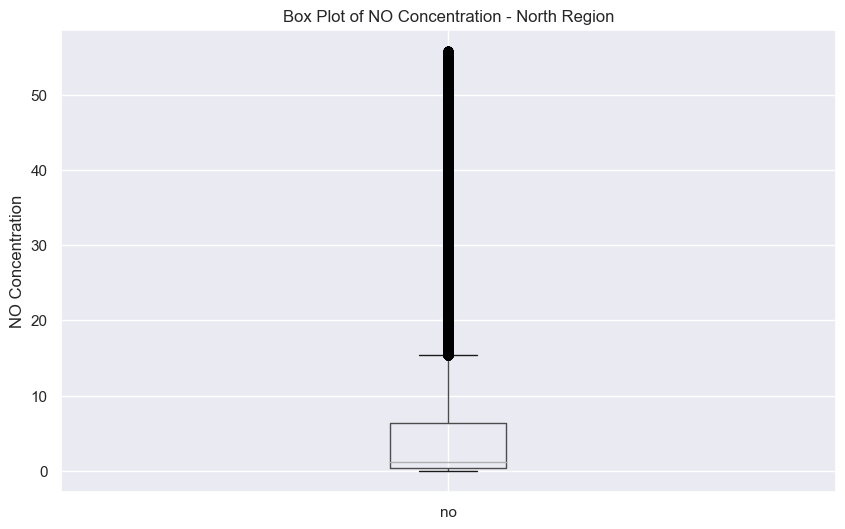

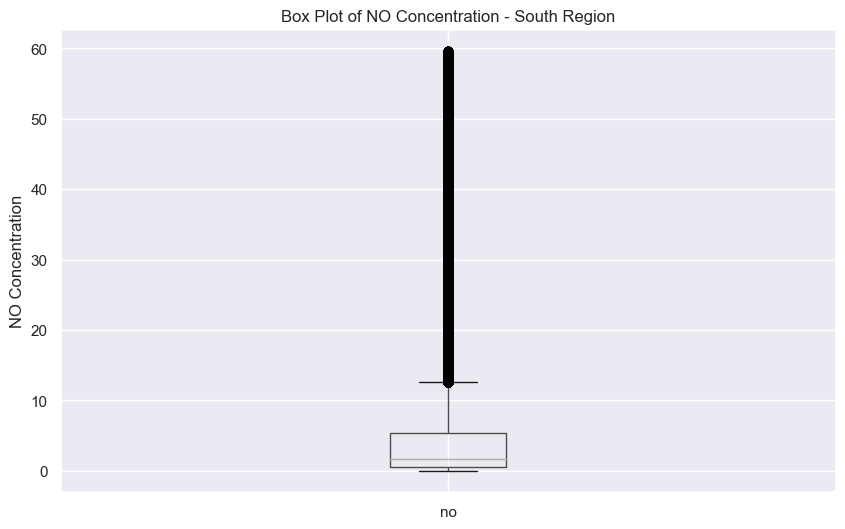

count    87672.000000
mean        10.197040
std          6.781343
min        -18.900000
25%          5.400000
50%          9.900000
75%         15.000000
max         36.400000
Name: temperature, dtype: float64
count    87672.000000
mean        11.091589
std          7.111453
min        -14.600000
25%          5.900000
50%         10.800000
75%         16.000000
max         39.300000
Name: temperature, dtype: float64


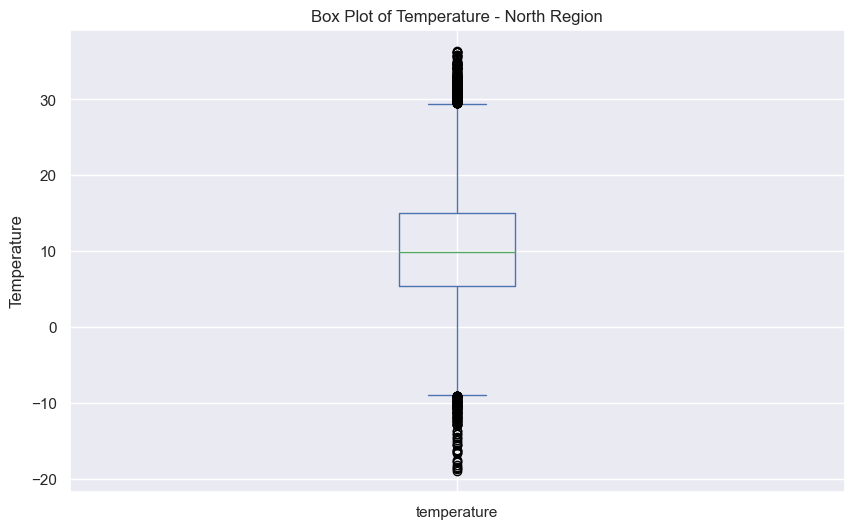

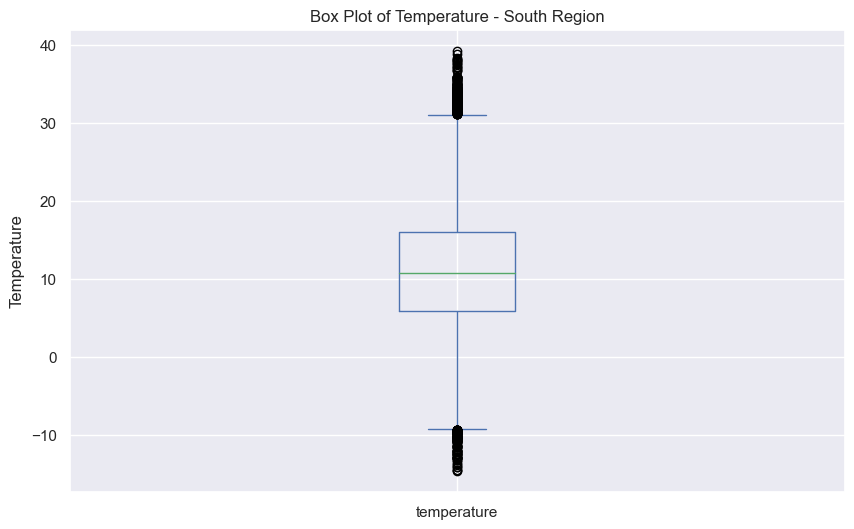

In [37]:
# check validity of the data
'''first we make a table with the most common characteristics 
of the data now we can make an indication of the validity combined 
with a box plot for extra insight.''' 

# Print descriptive statistics for NO concentration in the North region
print(df_no_north.describe())

# Print descriptive statistics for NO concentration in the South region
print(df_no_south.describe())

# These lines print the descriptive statistics of the NO concentration data for the North and South regions.
# Descriptive statistics include count, mean, standard deviation, min, quartiles, and max.
# This helps in understanding the central tendency, spread, and shape of the data distribution.

# Box plot for North Region
plt.figure(figsize=(10, 6))  # Set the size of the plot
df_no_north.boxplot()  # Create a box plot for the NO concentration in the North region
plt.title('Box Plot of NO Concentration - North Region')  # Title of the plot
plt.ylabel('NO Concentration')  # Label for the y-axis
plt.show()  # Display the plot

# Box plot for South Region
plt.figure(figsize=(10, 6))  # Set the size of the plot
df_no_south.boxplot()  # Create a box plot for the NO concentration in the South region
plt.title('Box Plot of NO Concentration - South Region')  # Title of the plot
plt.ylabel('NO Concentration')  # Label for the y-axis
plt.show()  # Display the plot

# These box plots provide a visual representation of the NO concentration data distribution in both regions.
# Box plots show the median, quartiles, and outliers, which helps in understanding the data's spread and identifying outliers.

# TEMP

# Print descriptive statistics for temperature in the North region
print(df_temp_north['temperature'].describe())

# Print descriptive statistics for temperature in the South region
print(df_temp_south['temperature'].describe())

# These lines print the descriptive statistics of the temperature data for the North and South regions.
# This includes similar statistical measures as for the NO concentration, providing an overview of the temperature data.

# Box plot for North Region Temperature
plt.figure(figsize=(10, 6))  # Set the size of the plot
df_temp_north['temperature'].plot(kind='box')  # Create a box plot for the temperature in the North region
plt.title('Box Plot of Temperature - North Region')  # Title of the plot
plt.ylabel('Temperature')  # Label for the y-axis
plt.show()  # Display the plot

# Box plot for South Region Temperature
plt.figure(figsize=(10, 6))  # Set the size of the plot
df_temp_south['temperature'].plot(kind='box')  # Create a box plot for the temperature in the South region
plt.title('Box Plot of Temperature - South Region')  # Title of the plot
plt.ylabel('Temperature')  # Label for the y-axis
plt.show()  # Display the plot

# These box plots for temperature data in both regions help in visualizing the distribution, median, quartiles, and outliers.
# This is useful for assessing the spread and identifying any unusual points in the temperature data.

# Explanation of the plots
# We have plotted multiple plots:
# We can see a lot of outliers but still a median that is within what's logical (after removal of some).
# Therefore, we can conclude our data is valid


<h3>Part 2d: Preparing dataframe for testing</h3>


In [38]:
# Arhan (until part 3)

#Calculating values for hypothesis pt.1
#This cell calculates average north winter temperature for the winter period (using data from 2012-2021).
#The winter period is defined (for all regions) in this project as starting 22nd Dec and ending 20th March
#This average winter temp. for the north will be used to compare against other regions that are above 4.5 degrees
# (as per our hypothesis)
#North is found to have an average winter temperature of 4.0 degrees Celsius (as shown below)

df_temp_north_edit = df_temp_north

def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

df_temp_north_edit = df_temp_north_edit.reset_index()
transform_datetime(df_temp_north_edit)
df_temp_north_edit

df_temp_north_edit.set_index(['Year','Month','Day'], inplace=True)

df_temp_north_edit

years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
avg_winter_temp_north = 0

for year in years:
    winter_north_start = df_temp_north_edit.loc[(year, 12, 22):(year+1, 3, 20), :]
    avg_winter_temp_north = avg_winter_temp_north + winter_north_start['temperature'].mean()
        #df_temp_south_edit.loc[year,12,22: year+1,3,20]
        #winter_south_end = df_temp_south_edit.loc[year+1,3,20]

#display(df_temp_north_edit)
print('Average north winter temp:', avg_winter_temp_north/9)
print('2020/2021 north winter temp:' ,winter_north_start['temperature'].mean())

Average north winter temp: 4.005243272298515
2020/2021 north winter temp: 3.1601123595505616


In [39]:
#Calculating values for hypothesis pt.2
#This cell calculates average south winter temperature for the winter period (using data from 2012-2021)
#The winter period is defined (for all regions) in this project as starting 22nd Dec and ending 20th March
#This average winter temp. for the south will be used to compare against other regions that are below 4.5 degrees
# (as per our hypothesis)
#South is found to have an average winter temperature of 4.7 degrees Celsius (as shown below)

df_temp_south_edit = df_temp_south

def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

df_temp_south_edit = df_temp_south_edit.reset_index()
transform_datetime(df_temp_south_edit)
df_temp_south_edit

df_temp_south_edit.set_index(['Year','Month','Day'], inplace=True)

df_temp_south_edit

years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
avg_winter_temp_south = 0

for year in years:
    winter_south_start = df_temp_south_edit.loc[(year, 12, 22):(year+1, 3, 20), :]
    avg_winter_temp_south = avg_winter_temp_south + winter_south_start['temperature'].mean()
        #df_temp_south_edit.loc[year,12,22: year+1,3,20]
        #winter_south_end = df_temp_south_edit.loc[year+1,3,20]

print('Average south winter temp:', avg_winter_temp_south/9)
print('2020/2021 south winter temp:' ,winter_south_start['temperature'].mean())

#df_temp_south_edit[winter_south_start]

Average south winter temp: 4.681685046469691
2020/2021 south winter temp: 4.362078651685394


In [40]:
#Calculating values for hypothesis pt.3
#This cell calculates average southwest winter temperature for the winter period (using data from 2012-2021)
#The winter period is defined (for all regions) in this project as starting 22nd Dec and ending 20th March
#This average winter temp. for the southwest will be used to compare against other regions that are below 4.5 degrees
# (as per our hypothesis)
#Southwest is found to have an average winter temperature of 5.2 degrees Celsius (as shown below)

df_temp_southwest_edit = df_temp_southwest

def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

df_temp_southwest_edit = df_temp_southwest_edit.reset_index()
transform_datetime(df_temp_southwest_edit)

df_temp_southwest_edit.set_index(['Year','Month','Day'], inplace=True)


years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
avg_winter_temp_southwest = 0

for year in years:
    winter_southwest_start = df_temp_southwest_edit.loc[(year, 12, 22):(year+1, 3, 20), :]
    avg_winter_temp_southwest = avg_winter_temp_southwest + winter_southwest_start['temperature'].mean()
        #df_temp_south_edit.loc[year,12,22: year+1,3,20]
        #winter_south_end = df_temp_south_edit.loc[year+1,3,20]

print('Average southwest winter temp:', avg_winter_temp_southwest/9)
print('2020/2021 southwest winter temp:' ,winter_southwest_start['temperature'].mean())

#df_temp_south_edit[winter_south_start]

Average southwest winter temp: 5.203134738983677
2020/2021 southwest winter temp: 4.602574906367041


In [41]:
#Calculating values for hypothesis pt.4
#This cell calculates average east winter temperature for the winter period (using data from 2012-2021)
#The winter period is defined (for all regions) in this project as starting 22nd Dec and ending 20th March
#This average winter temp. for the east will be used to compare against other regions that are above 4.5 degrees
# (as per our hypothesis)
#East is found to have an average winter temperature of 4.2 degrees Celsius (as shown below)

df_temp_east_edit = df_temp_east

def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

df_temp_east_edit = df_temp_east_edit.reset_index()
transform_datetime(df_temp_east_edit)

df_temp_east_edit.set_index(['Year','Month','Day'], inplace=True)


years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
avg_winter_temp_east = 0

for year in years:
    winter_east_start = df_temp_east_edit.loc[(year, 12, 22):(year+1, 3, 20), :]
    avg_winter_temp_east = avg_winter_temp_east + winter_east_start['temperature'].mean()
        #df_temp_south_edit.loc[year,12,22: year+1,3,20]
        #winter_south_end = df_temp_south_edit.loc[year+1,3,20]

print('Average east winter temp:', avg_winter_temp_east/9)
print('2020/2021 east winter temp:' ,winter_east_start['temperature'].mean())

#df_temp_south_edit[winter_south_start]

Average east winter temp: 4.165188190687566
2020/2021 east winter temp: 3.545271535580525


In [42]:
#Calculating values for hypothesis 5
#This cell calculates the median NO concentration for the winter period for the whole country
#This will be used when completing hypothesis testing as the number obtained from this calculation (2.7) will be 
#used as a threshold where we will measure how many times a certain region's NO concentration exceeds 2.7 to 
#determine which has higher levels of NO overall (as per our hypothesis)
#Note: median was used to limit effects of outliers

def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

df_no_edit = df_no_edit.reset_index()
transform_datetime(df_no_edit)

df_no_edit.set_index(['Year','Month','Day'], inplace=True)

years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
all_winter_no_values = []

df_no_edit.sort_index(inplace=True)

for year in years:
    no_values = df_no_edit.loc[(year, 12, 22):(year+1, 3, 20), 'no'].dropna().tolist()
    all_winter_no_values += no_values

national_no_winter_median = np.median(all_winter_no_values)

print("Median of 'no' values for the winter period:", national_no_winter_median)


Median of 'no' values for the winter period: 2.7


In [43]:
#Merging/conversion of dataframes

In [44]:
#Converts each region's NO dataframe to per hour (indexed by actual date, not datetime)

#Function to perform action
def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

#Resetting index, converting datetime to individual date columns, setting index to date columns, removing 'datetime'

df_no_north_final = df_no_north.reset_index()
df_no_north_per_hour = transform_datetime(df_no_north_final)

df_no_north_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_no_north_per_hour.sort_index(inplace=True)

df_no_north_per_hour.drop(columns=['datetime'], inplace=True)

display(df_no_north_per_hour)

#Displays certain sections of the dataframe (like winter dates only for example - good to keep for data analysis)
#display(df_no_north_per_hour.loc[(2018, 12, 22), :])
#df_no_north_per_hour.loc[(2018, 12, 22):(2018, 12, 23),:]

station_code     no
Year Month Day Hour                    
2012 1     1   1         NL10929   0.58
               1         NL10937  40.02
               1         NL10938   7.13
               2         NL10929   0.16
               2         NL10937  22.09
...                          ...    ...
2021 12    31  22        NL10937   2.78
               22        NL10938  10.79
               23        NL10929   0.20
               23        NL10937   2.47
               23        NL10938   2.20

[231987 rows x 2 columns]

In [45]:
#Resetting index, converting datetime to individual columns, setting index to date columns
#Same process as previous cell but for the south, southwest, and east regions

#South
df_no_south_final = df_no_south.reset_index()
df_no_south_per_hour = transform_datetime(df_no_south_final)

df_no_south_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_no_south_per_hour.sort_index(inplace=True)

df_no_south_per_hour.drop(columns=['datetime'], inplace=True)


#Southwest
df_no_southwest_final = df_no_southwest.reset_index()
df_no_southwest_per_hour = transform_datetime(df_no_southwest_final)

df_no_southwest_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_no_southwest_per_hour.sort_index(inplace=True)

df_no_southwest_per_hour.drop(columns=['datetime'], inplace=True)


#East
df_no_east_final = df_no_east.reset_index()
df_no_east_per_hour = transform_datetime(df_no_east_final)

df_no_east_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_no_east_per_hour.sort_index(inplace=True)

df_no_east_per_hour.drop(columns=['datetime'], inplace=True)



#display(df_no_east_per_hour)

In [46]:
#Converts each region's temperature dataframe to per hour (index by date)
#Same process as previous two cells but for the north temperature dataframe

df_temp_north_final = df_temp_north.reset_index()
df_temp_north_per_hour = transform_datetime(df_temp_north_final)

df_temp_north_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_temp_north_per_hour.sort_index(inplace=True)

df_temp_north_per_hour.drop(columns=['datetime'], inplace=True)

#df_temp_north_per_hour

#Displays certain sections of the dataframe (like winter dates only for example - good to keep for data analysis)
#display(df_no_north_per_hour.loc[(2018, 12, 22), :])
#df_temp_north_per_hour.loc[(2018, 12, 22):(2019, 3, 21),:]

In [47]:
#Same process as previous three cells but for the south, southwest, and east temperature dataframes

#South
df_temp_south_final = df_temp_south.reset_index()
df_temp_south_per_hour = transform_datetime(df_temp_south_final)

df_temp_south_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_temp_south_per_hour.sort_index(inplace=True)

df_temp_south_per_hour.drop(columns=['datetime'], inplace=True)


#Southwest
df_temp_southwest_final = df_temp_southwest.reset_index()
df_temp_southwest_per_hour = transform_datetime(df_temp_southwest_final)

df_temp_southwest_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_temp_southwest_per_hour.sort_index(inplace=True)

df_temp_southwest_per_hour.drop(columns=['datetime'], inplace=True)


#East
df_temp_east_final = df_temp_east.reset_index()
df_temp_east_per_hour = transform_datetime(df_temp_east_final)

df_temp_east_per_hour.set_index(['Year','Month','Day','Hour'], inplace=True)
df_temp_east_per_hour.sort_index(inplace=True)

df_temp_east_per_hour.drop(columns=['datetime'], inplace=True)

In [48]:
#Merges the NO and temperature dataframe of each region (indexed by date)

#Adds an extra boolean column that determines if each NO value exceeds national winter median (found to be 2.7)
#NOTE: This is done for every row entry, even if it is not in the winter 
# (dataframes will be restricted to the winter period in a future cell)

#Adds an extra two columns that calculates difference in NO and temperature from the previous row 
#(useful in determining whether big changes in temperature result in big changes in NO or vice-versa)

#Renames station code columns
df_no_north_per_hour_final = df_no_north_per_hour.merge(df_temp_north_per_hour, left_index=True, right_index=True)
df_no_north_per_hour_final.rename(columns={'station_code_x': 'station_code_air_quality', 'station_code_y': 'station_code_temperature'}, inplace=True)

#Boolean column exceeding national NO median
df_no_north_per_hour_final['exceeds_national_no_winter_median'] = (df_no_north_per_hour_final['no'] > national_no_winter_median).astype(int)

#Columns calculating difference in NO and temperature from the previous row 
df_no_north_per_hour_final['difference_no'] = df_no_north_per_hour_final['no'].diff()
df_no_north_per_hour_final['difference_temp'] = df_no_north_per_hour_final['temperature'].diff()

#How it looks like now
display(df_no_north_per_hour_final)

#Example use of it in analsyis (2018/2019 winter):
#test = df_no_north_per_hour_final.loc[(2018,12, 22):(2019, 3, 21),:]

station_code_air_quality     no  station_code_temperature  \
Year Month Day Hour                                                             
2012 1     1   1                     NL10929   0.58                       280   
               1                     NL10937  40.02                       280   
               1                     NL10938   7.13                       280   
               2                     NL10929   0.16                       280   
               2                     NL10937  22.09                       280   
...                                      ...    ...                       ...   
2021 12    31  22                    NL10937   2.78                       280   
               22                    NL10938  10.79                       280   
               23                    NL10929   0.20                       280   
               23                    NL10937   2.47                       280   
               23                    NL10938   2.20                       280   

                     temperature  exceeds_national_no_winter_median  \
Year Month Day Hour                                                   
2012 1     1   1            10.0                                  0   
               1            10.0                                  1   
               1            10.0                                  1   
               2            10.1                                  0   
               2            10.1                                  1   
...                          ...                                ...   
2021 12    31  22           11.0                                  1   
               22           11.0                                  1   
               23           10.7                                  0   
               23           10.7                                  0   
               23           10.7                                  0   

                     difference_no  difference_temp  
Year Month Day Hour                                  
2012 1     1   1               NaN              NaN  
               1             39.44              0.0  
               1            -32.89              0.0  
               2             -6.97              0.1  
               2             21.93              0.0  
...                            ...              ...  
2021 12    31  22             2.53              0.0  
               22             8.01              0.0  
               23           -10.59             -0.3  
               23             2.27              0.0  
               23            -0.27              0.0  

[231987 rows x 7 columns]

In [49]:
#Same process as previous cell but now on south,southwest, and east dataframes

#South
df_no_south_per_hour_final = df_no_south_per_hour.merge(df_temp_south_per_hour, left_index=True, right_index=True)
df_no_south_per_hour_final.rename(columns={'station_code_x': 'station_code_air_quality', 'station_code_y': 'station_code_temperature'}, inplace=True)


df_no_south_per_hour_final['exceeds_national_no_winter_median'] = (df_no_south_per_hour_final['no'] > national_no_winter_median).astype(int)


df_no_south_per_hour_final['difference_no'] = df_no_south_per_hour_final['no'].diff()
df_no_south_per_hour_final['difference_temp'] = df_no_south_per_hour_final['temperature'].diff()


#Southwest
df_no_southwest_per_hour_final = df_no_southwest_per_hour.merge(df_temp_southwest_per_hour, left_index=True, right_index=True)
df_no_southwest_per_hour_final.rename(columns={'station_code_x': 'station_code_air_quality', 'station_code_y': 'station_code_temperature'}, inplace=True)


df_no_southwest_per_hour_final['exceeds_national_no_winter_median'] = (df_no_southwest_per_hour_final['no'] > national_no_winter_median).astype(int)


df_no_southwest_per_hour_final['difference_no'] = df_no_southwest_per_hour_final['no'].diff()
df_no_southwest_per_hour_final['difference_temp'] = df_no_southwest_per_hour_final['temperature'].diff()

#East
df_no_east_per_hour_final = df_no_east_per_hour.merge(df_temp_east_per_hour, left_index=True, right_index=True)
df_no_east_per_hour_final.rename(columns={'station_code_x': 'station_code_air_quality', 'station_code_y': 'station_code_temperature'}, inplace=True)


df_no_east_per_hour_final['exceeds_national_no_winter_median'] = (df_no_east_per_hour_final['no'] > national_no_winter_median).astype(int)


df_no_east_per_hour_final['difference_no'] = df_no_east_per_hour_final['no'].diff()
df_no_east_per_hour_final['difference_temp'] = df_no_east_per_hour_final['temperature'].diff()




In [50]:
#This cell creates a new dataframe for each region that is just a restricted version of the dataframes made in the
#previous two cells. This is to make sure the analsyis is only done on the winter period of each year, hence the 
# for loops present down below (iterating through winter in the data)

#This process is completed for all regions and the dataframes created as a result will be the final ones used in
#hypothesis testing

df_north_final = pd.DataFrame()

for year in range(2012, 2021):
    #filters for the current year and winter period
    winter_year = df_no_north_per_hour_final.loc[(year, 12, 22):(year+1, 3, 21), :]
    
    winter_year = winter_year.reset_index()
    
    #print(f"Year: {year}, Rows before appending: {len(df_no_north_final)}, Rows in winter_year: {len(winter_year)}")
    
    #df_no_north_final = df_no_north_final.append(winter_year) #appends is going out in future
    df_north_final = pd.concat([df_north_final, winter_year],  ignore_index=True)
    
    #print(f"Year: {year}, Rows after appending: {len(df_no_north_final)}")

    
df_north_final = df_north_final.set_index(['Year', 'Month', 'Day','Hour'])


#South
df_south_final = pd.DataFrame()

for year in range(2012, 2021):
    #filters for the current year and winter period
    winter_year = df_no_south_per_hour_final.loc[(year, 12, 22):(year+1, 3, 21), :]
    
    winter_year = winter_year.reset_index()
    
    df_south_final = pd.concat([df_south_final, winter_year],  ignore_index=True)
    
df_south_final = df_south_final.set_index(['Year', 'Month', 'Day','Hour'])


#Southwest
df_southwest_final = pd.DataFrame()

for year in range(2012, 2021):
    #filters for the current year and winter period
    winter_year = df_no_southwest_per_hour_final.loc[(year, 12, 22):(year+1, 3, 21), :]
    
    winter_year = winter_year.reset_index()
    
    df_southwest_final = pd.concat([df_southwest_final, winter_year],  ignore_index=True)
    
df_southwest_final = df_southwest_final.set_index(['Year', 'Month', 'Day','Hour'])
    
    
#East
df_east_final = pd.DataFrame()

for year in range(2012, 2021):
    #filters for the current year and winter period
    winter_year = df_no_east_per_hour_final.loc[(year, 12, 22):(year+1, 3, 21), :]
    
    winter_year = winter_year.reset_index()
    
    df_east_final = pd.concat([df_east_final, winter_year],  ignore_index=True)
    
df_east_final = df_east_final.set_index(['Year', 'Month', 'Day','Hour'])


In [51]:
#For average temperature value in hypothesis (4.5):
#To find an appropriate amount of regions over and under a certain average winter temperature in the hypothesis
#is crucial. This allows us to do a pairwise comparison of NO concentration with one region below the average winter
#temperature compare to one above the average winter temperature.

#This cell finds the average winter temp. to be 4.5 (this allows for the north and east to fall below this avg and
#south and southwest to be above, so the comparison is viable).

df_temp_editt = df_temp
df_temp_editt.dropna(inplace=True)

def transform_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    return df

df_temp_editt = df_temp_editt.reset_index()
transform_datetime(df_temp_editt)

df_temp_editt.set_index(['Year','Month','Day'], inplace=True)
df_temp_editt.sort_index(inplace=True)
winter_test = pd.DataFrame()
avg_winter_temp = 0


years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]

for year in years:
    winter_test = df_temp_editt.loc[(year, 12, 22):(year+1, 3, 20), :]
    avg_winter_temp = avg_winter_temp + winter_test['temperature'].mean()

print('Average winter temp:', avg_winter_temp/9)
print('2020/2021 winter temp:' ,winter_test['temperature'].mean())

Average winter temp: 4.513812812109862
2020/2021 winter temp: 3.917509363295881


In [52]:
#Final dataframes going to be used in HYP:
df_north_final
df_south_final
df_southwest_final
df_east_final

station_code_air_quality     no  station_code_temperature  \
Year Month Day Hour                                                             
2012 12    22  0                     NL10722  14.52                       290   
               4                     NL10722   6.40                       290   
               5                     NL10722   0.77                       290   
               6                     NL10722   0.31                       290   
               7                     NL10722   0.28                       290   
...                                      ...    ...                       ...   
2021 3     21  4                     NL10722   0.04                       290   
               8                     NL10722   0.35                       290   
               10                    NL10722   0.04                       290   
               12                    NL10722   0.06                       290   
               13                    NL10722   0.06                       290   

                     temperature  exceeds_national_no_winter_median  \
Year Month Day Hour                                                   
2012 12    22  0             1.8                                  1   
               4             6.7                                  1   
               5             6.9                                  0   
               6             6.8                                  0   
               7             6.8                                  0   
...                          ...                                ...   
2021 3     21  4             5.7                                  0   
               8             6.3                                  0   
               10            7.4                                  0   
               12            7.3                                  0   
               13            7.1                                  0   

                     difference_no  difference_temp  
Year Month Day Hour                                  
2012 12    22  0              1.84              0.3  
               4             -8.12              4.9  
               5             -5.63              0.2  
               6             -0.46             -0.1  
               7             -0.03              0.0  
...                            ...              ...  
2021 3     21  4             -0.02              0.0  
               8              0.31              0.6  
               10            -0.31              1.1  
               12             0.02             -0.1  
               13             0.00             -0.2  

[15787 rows x 7 columns]

## Part 3. Hypothesis testing and interpretation

Arhan/Eytan:

HYP:

We are performing both proportion and means testing as we have the appropriate data for both. A boolean column
measuring the number of occurences a certain threshold of NO concentration in winter is exceeded and the actual NO
concentration of each region during the winter period.

For both, the tests are two sample as the data consists of two seperate samples and are one sided.

Proportion: We want to find the number of times that each region records an NO concentration 
    value over the national median thereshold during the winter period.
    
    two-sample proportions H0: 𝑝1 = 𝑝2 ; 𝐻𝑎: 𝑝1 > 𝑝2
    
Means: We want to find the average concentration of NO for each region during the winter and determine which is higher.
    
    𝐻0: 𝜇1 = 𝜇2; 𝐻𝑎: 𝜇1 > 𝜇 2
            
            𝑝1 = north (or region with average winter temp. below 4.5)
            𝑝2 = southwest (or region with average winter temp. above 4.5)
            
            𝜇1 = north (or region with average winter temp. below 4.5)
            𝜇2 = southwest (or region with average winter temp. above 4.5)
            


In [53]:
#Determining number of entries per df

len(df_north_final)
len(df_south_final)
len(df_southwest_final)
len(df_east_final)

15787

In [54]:
# Eytan, Arhan (until part 4)

#Testing (ignore)
total_exceeds_national_no_median_north = df_north_final['exceeds_national_no_winter_median'].sum()
total_north = df_north_final['exceeds_national_no_winter_median'].count()

rate_exceeds_north = total_exceeds_national_no_median_north / total_north

print(total_exceeds_national_no_median_north)
print(total_north)
print(rate_exceeds_north)


df_north_final #Just to see data you are working with

18522
51671
0.35846025817189525


station_code_air_quality     no  station_code_temperature  \
Year Month Day Hour                                                             
2012 12    22  0                     NL10929   0.49                       280   
               0                     NL10937  20.89                       280   
               0                     NL10938   0.37                       280   
               1                     NL10929   1.18                       280   
               1                     NL10937  15.76                       280   
...                                      ...    ...                       ...   
2021 3     21  21                    NL10938   0.47                       280   
               22                    NL10937   0.76                       280   
               22                    NL10938   0.65                       280   
               23                    NL10937   0.33                       280   
               23                    NL10938   0.18                       280   

                     temperature  exceeds_national_no_winter_median  \
Year Month Day Hour                                                   
2012 12    22  0            -0.4                                  0   
               0            -0.4                                  1   
               0            -0.4                                  0   
               1            -0.4                                  0   
               1            -0.4                                  1   
...                          ...                                ...   
2021 3     21  21            3.3                                  0   
               22            4.5                                  0   
               22            4.5                                  0   
               23            4.8                                  0   
               23            4.8                                  0   

                     difference_no  difference_temp  
Year Month Day Hour                                  
2012 12    22  0              0.11              0.0  
               0             20.40              0.0  
               0            -20.52              0.0  
               1              0.81              0.0  
               1             14.58              0.0  
...                            ...              ...  
2021 3     21  21            -5.32              0.0  
               22             0.29              1.2  
               22            -0.11              0.0  
               23            -0.32              0.3  
               23            -0.15              0.0  

[51671 rows x 7 columns]

In [55]:
#propotions test

#We are not performing any tests of normality (for both proprtions and means)
#as we can confidently assume that both samples are normally distributed due to each data sample having 
#more than 50 entries in their dataframes/samples.

def perform_z_test(df, df_2):
    
    # Extract data from DataFrame columns
    exceeds_median_1 = df['exceeds_national_no_winter_median']
    #no_data = df['no']

    
    positive_count_1 = sum(exceeds_median_1)  
    total_count_1 = len(exceeds_median_1)
    #total_count_real = exceeds_median.count()
    
    
    exceeds_median_2 = df_2['exceeds_national_no_winter_median']
    #no_data = df_2['no']

    
    positive_count_2 = sum(exceeds_median_2)  
    total_count_2 = len(exceeds_median_2)
    #total_count_real = exceeds_median.count()
    
    #print(positive_count_1)
    #print(positive_count_2)
    #print(total_count_1)
    #print(total_count_2)
    
    #z_stat, p_value = sm.stats.proportions_ztest(positive_count, total_count, value=0.5, alternative='larger')
    z_stat, p_value = sm.stats.proportions_ztest([positive_count_1, positive_count_2], [total_count_1, total_count_2], alternative='larger')

    
    # Display the results
    print(f" Z statistic: {z_stat}, p-value: {p_value}")
    

# Perform z-tests for each possible dataframe combination
# As per our hypothesis, we can only compare a region with average winter temp. less than 4.5 degrees Celsius 
#with one over 4.5. And our alternative hypothesis states that the region with the lowest avg temp. has a greater 
#proportion of NO concentration exceeding threshold. Only four combinations of regions satisfy this condition.

# Combinations examined:
#North > Southwest, East > South, East > Southwest, North > South

print('Comparing proportions of winter NO conc. exceeding the winter median\n')

print('North > Southwest:', end=' ')
perform_z_test(df_north_final, df_southwest_final)

print('East > South:', end=' ')
perform_z_test(df_east_final, df_south_final)

print('East > Southwest:', end=' ')
perform_z_test(df_east_final, df_southwest_final)

print('North > South:', end=' ')
perform_z_test(df_north_final,df_south_final)


# Combinations examined (not part of hypothesis)

print('\n\nSouth > Southwest:', end=' ')
perform_z_test(df_south_final,df_southwest_final)

print('North > East:', end=' ')
perform_z_test(df_north_final, df_east_final)



Comparing proportions of winter NO conc. exceeding the winter median

North > Southwest:  Z statistic: -135.81419876626776, p-value: 1.0
East > South:  Z statistic: -63.52851064805756, p-value: 1.0
East > Southwest:  Z statistic: -136.08719365382063, p-value: 1.0
North > South:  Z statistic: -17.55377333728353, p-value: 1.0


South > Southwest:  Z statistic: -137.77713718529864, p-value: 1.0
North > East:  Z statistic: 51.848621243334186, p-value: 0.0


In [56]:
#comparing means


print('\n\nTwo sample:')
print('Comparing means of winter NO conc.\n')

def perform_t_test_compare(df,df_2):
    d_region_1 = sm.stats.DescrStatsW(df['no'])
    d_region_2 = sm.stats.DescrStatsW(df_2['no'])
    
    cm_regions = sm.stats.CompareMeans(d_region_1, d_region_2)
    
    p_regions = cm_regions.ttest_ind(alternative='larger')[1]
    
    print(p_regions)
    

# As per our hypothesis, we can only compare a region with average winter temp. less than 4.5 degrees Celsius 
#with one over 4.5. And our alternative hypothesis states that the region with the lowest avg temp. has greater 
# NO concentration overall (measured through means in this case). 
#Only four combinations of regions satisfy this condition.

# Combinations examined:
#North > Southwest, East > South, East > Southwest, North > South
    
print('North > Southwest:', end=' ')
perform_t_test_compare(df_north_final, df_southwest_final)

print('East > South:', end=' ')
perform_t_test_compare(df_east_final, df_south_final)

print('East > Southwest:', end=' ')
perform_t_test_compare(df_east_final, df_southwest_final)

print('North > South:', end=' ')
perform_t_test_compare(df_north_final,df_south_final)




# Combinations examined (not part of hypothesis)
print('\n\nSouth > Southwest:', end=' ')
perform_t_test_compare(df_south_final,df_southwest_final)

print('North > East:', end=' ')
perform_t_test_compare(df_north_final, df_east_final)





Two sample:
Comparing means of winter NO conc.

North > Southwest: 1.0
East > South: 1.0
East > Southwest: 1.0
North > South: 0.8372753111860092


South > Southwest: 1.0
North > East: 0.0


In [57]:
#3. Analyze and interpret the results.
#Interpret the results in light of your original hypothesis. It is important to not only look at the result of the test, but also to think about what this result means. Can you think of any other reason for the results being the way they are?
#4. Reflect on your hypothesis.
#Once you have results for your hypotheses, you can now try to argue for or against your original hypothesis. Is it true? False? Or are there other explanations for what you’ve seen?

With the exception of "North vs. East," the Z-statistics and p-values for all region comparisons indicate that there are no statistically significant variations in NO concentration between the designated regions. 

Since all of the p-values are near to 1.0, the null hypothesis of equal means cannot be rejected. In contrast, the p-value for "North vs. East" is 0.0, which is below the standard significance level of 0.05. This implies that the NO concentrations in the North and East differ considerably but this is not a part of our actual hypothesis testing as both average winter temperatures are below 4.5. The difference provides support to our theory, suggesting that these two probably differ in significant ways albeit cannot be used to evaluate our hypothesis. Additionally,a proportions test was conducted  to further examine potential differences in NO concentrations between regions. Similar to the Z-statistics results, the proportions test revealed no statistically significant variations in NO concentration among all regions, except for "North vs. East". The p-values for the proportions test echoed the findings, with values close to 1.0 for all comparisons except "North vs. East," where the p-value was 0.0

The lack of correlation in other pairwise comparisons could be caused by other factors that were not taken into account during the analysis. For instance, regional pollution sources, weather factors. 

In conclusion our original hypothesis is not supported. While differences were found between North and East, other regions did not show significant disparities in NO concentrations. Further investigation into the specific causes of the observed differences and consideration of additional variables could enhance the understanding of the results.




## Part 4. Polishing and pitching results

In [58]:
# This section is only for generating figures if you need it. You may leave it empty.

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [59]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)

feedback_time = 10

#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

10


### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [60]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)

feedback_difficulty = 7

#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

7


### (Optional) What did you like?

Assign a string to `feedback_like`.

In [61]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [62]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [63]:
# List all defined names
%whos

Variable                                 Type                          Data/Info
--------------------------------------------------------------------------------
AUTHOR_ID_NRS                            list                          n=4
DecisionTreeClassifier                   ABCMeta                       <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
ECDF                                     type                          <class 'statsmodels.distr<...>rical_distribution.ECDF'>
KMeans                                   ABCMeta                       <class 'sklearn.cluster._kmeans.KMeans'>
Line2D                                   type                          <class 'matplotlib.lines.Line2D'>
LinearRegression                         ABCMeta                       <class 'sklearn.linear_mo<...>._base.LinearRegression'>
Point                                    type                          <class 'shapely.geometry.point.Point'>
QUERY_AQ                                 str           

winter_south_start                       DataFrame                                     station_c<...>\n[2136 rows x 4 columns]
winter_southwest_start                   DataFrame                                     station_c<...>\n[2136 rows x 4 columns]
winter_test                              DataFrame                                      index  t<...>\n[8544 rows x 5 columns]
winter_year                              DataFrame                           Year  Month  Day  H<...>n[1996 rows x 11 columns]
year                                     int                           2020
years                                    list                          n=9


---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology